In [1]:
#General imports for Plotting and Data manipulation 
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
%matplotlib inline
from matplotlib.ticker import MaxNLocator
from IPython.display import clear_output
from packaging import version
from datetime import datetime, timedelta

#Tensorflow imports
import tensorflow as tf 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

#Sklearn imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics

#Keras imports
import keras
from keras import datasets
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.layers import PReLU, LeakyReLU, Conv2D, MaxPool2D, Lambda
from keras.regularizers import l2
from keras.models import model_from_json

In [2]:
# Define some useful functions for plotting 
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121) 
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)         
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();


In [3]:
#Import Stock Data
data = pd.read_csv(r"C:\Users\Harry\Desktop\College\Year 5\CS7CS4 - MACHINE LEARNING\ISEQ_data.csv")
stock_open_prices = data['Open'].astype(np.float32)
stock_dates = data['Date']

stock_open_prices = np.array(stock_open_prices)
stock_dates = np.array(stock_dates)

stock = data.iloc[:, 1:2].values

#Adding day of week Number as feature
data['Date'] = pd.to_datetime(data['Date'],format='%Y-%m-%d')
data['dayofweek_num'] = data['Date'].dt.dayofweek  
data['DateIndex'] = np.arange(data.shape[0])

data.head(100)

cl = data.iloc[:, 2].values
scl = MinMaxScaler()
#Reshape the data
cl = cl.reshape(cl.shape[0],1)
cl = scl.fit_transform(cl)

In [22]:
#Create a function to process the data into 7 day look back slices 
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)

print("cl shape is: ", cl.shape)
#Process the data into the 7 day look back slices
X,y = processData(cl,50)

#Split data into into training and testing and into axes (With 80:20 Split)
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)

cl2 = data['dayofweek_num']
cl2 = cl2.values.astype('float32')
cl2 = cl2.reshape(cl2.shape[0], 1)
print("cl2 shape is: ",cl2.shape)

X1, y1 = processData(cl2,50)

X_trainDN, X_testDN = train_test_split(X1, test_size=0.2, shuffle=False)
y_trainDN, y_testDN = train_test_split(y1, test_size=0.2, shuffle=False)

#X_train = X_train.reshape(X_train.shape[0])
#X_test = X_test.reshape(X_test.shape[0])

X_train = np.dstack((X_train, X_trainDN))
X_test = np.dstack((X_test, X_testDN))


print("X train shape is", X_train.shape)
print("X train DN shape is", X_trainDN.shape)

print("")

print("X test shape is", X_test.shape)
print("X test DN shape is", X_testDN.shape)
print("")

print("y test shape is",y_test.shape)

cl shape is:  (468, 1)
cl2 shape is:  (468, 1)
X train shape is (333, 50)
X train DN shape is (333, 50)

X test shape is (84, 50)
X test DN shape is (84, 50)

y test shape is (84,)


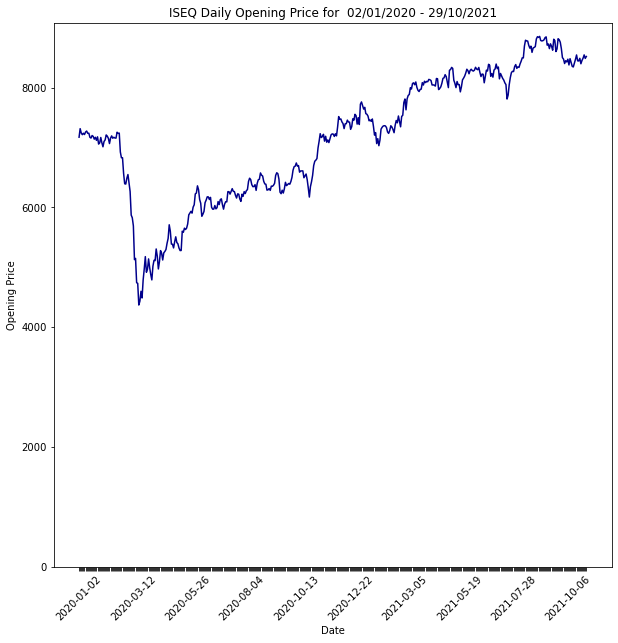

In [23]:
#visualise data

fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.plot(stock_dates,
        data['Open'],
        color='darkblue')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Opening Price",
       title="ISEQ Daily Opening Price for  02/01/2020 - 29/10/2021")

ax.set_ylim(ymin=0)

plt.setp(ax.get_xticklabels(), rotation=45)
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::50]))
for label in temp:
    label.set_visible(False)

plt.show()

In [57]:
input_shape = (50, 1)

#Now we create our LSTM model 
model = Sequential()

#Add layers 
model.add(LSTM(units = 96, return_sequences = True, input_shape = (50, 1))) #n lags, n features
model.add(Dropout(0.2))
model.add(LSTM(units = 96, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 96, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 96))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#Reshape Train and test sets to fit correctly with LSTM 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1], 1))

model.summary()
model.save_weights('model.h5')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 50, 192)           148992    
_________________________________________________________________
dropout_28 (Dropout)         (None, 50, 192)           0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 50, 192)           295680    
_________________________________________________________________
dropout_29 (Dropout)         (None, 50, 192)           0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 50, 192)           295680    
_________________________________________________________________
dropout_30 (Dropout)         (None, 50, 192)           0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 192)              

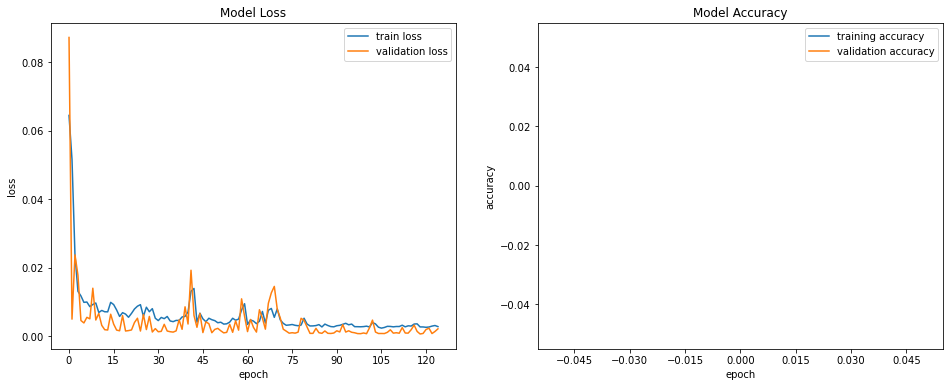

	Model Loss based on ISEQ stock data 
	after 125 Epochs in training


In [58]:
#Establish number of epochs and train model 
num_epochs = 125
pltCallBack = PlotLossAccuracy()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=num_epochs, callbacks=[PlotLossAccuracy()], batch_size=64, verbose=1,shuffle=False) 
print("\tModel Loss based on ISEQ stock data \n\tafter %i Epochs in training" %num_epochs)

Prediction Shape is:  (84, 1)


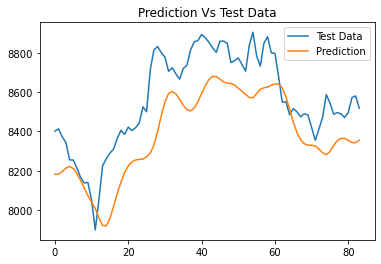

In [59]:
#We now visualise the training data and prediction
Xt = model.predict(X_test)

plt.plot(scl.inverse_transform(y_test.reshape(-1,1)) , label = 'Test Data')
print("Prediction Shape is: ", Xt.shape)

plt.plot(scl.inverse_transform(Xt), label = 'Prediction')
prediction = scl.inverse_transform(Xt)
plt.legend()
plt.title('Prediction Vs Test Data')
plt.show()

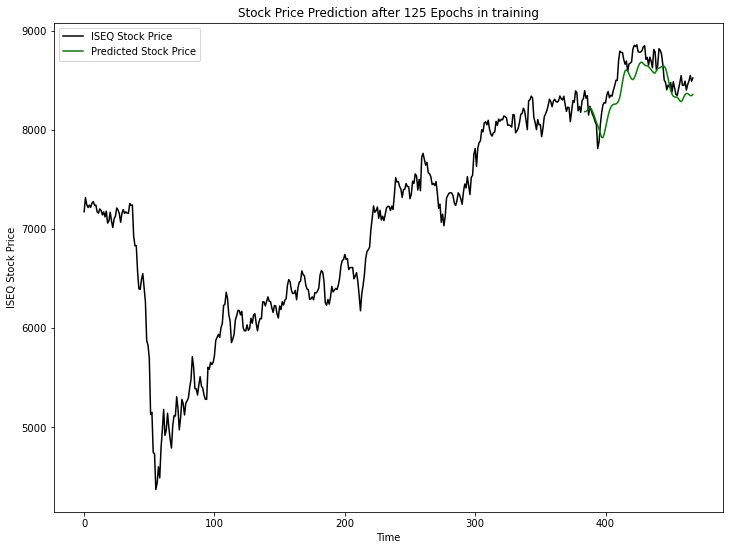

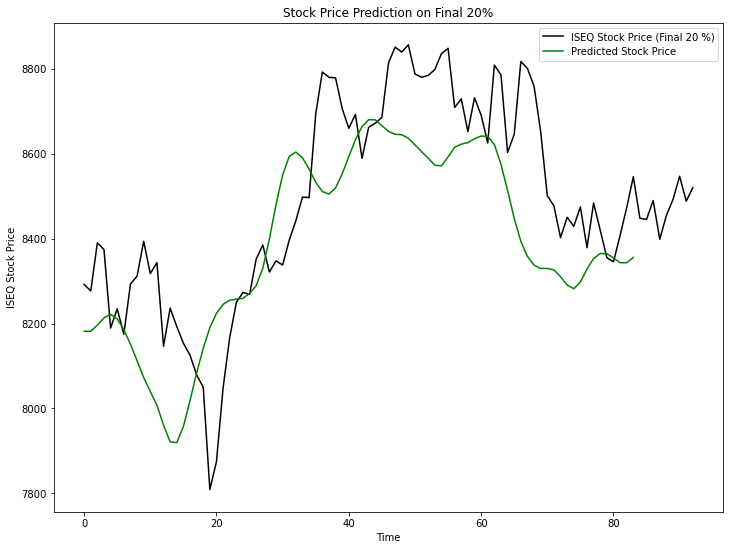

In [60]:
#We visualise the original data vs the Prediction of the final 20% of the stock data
prediction_main = np.zeros([468, 1], dtype = float) 
for i in range(0, 468):
    prediction_main[i] = None

for i in range(84, 168):
    prediction_main[i+300] = prediction[i - 84]

final40NKE = np.zeros([84, 1], dtype = float) 
for i in range(384, 468):
    final40NKE[i-384] = stock[i]  
    
prediction_main2 = np.zeros([84, 1], dtype = float) 
for i in range(0, 84):
    prediction_main2[i] = prediction_main[i+384]

fig, ax = plt.subplots(figsize=(12,9))
plt.plot(stock, color = 'black', label = 'ISEQ Stock Price')
plt.plot(prediction_main, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction after %i Epochs in training' %num_epochs)
plt.xlabel('Time')
plt.ylabel('ISEQ Stock Price')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12,9))    
plt.plot(stock[375:468, :], color = 'black', label = 'ISEQ Stock Price (Final 20 %)')
plt.plot(prediction_main2, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction on Final 20%')
plt.xlabel('Time')
plt.ylabel('ISEQ Stock Price')
plt.legend()

plt.show()


In [61]:
#Model Params
print("Model intercept (LSTM):", model)  # Printing model intercept
print()
print("Mean absolute error (LSTM): \t", metrics.mean_absolute_error(y_test, Xt))  # Printing Mean absolute error
print("Mean squared error (LSTM): \t", metrics.mean_squared_error(y_test, Xt))  # Printing mean squared error
print("R squared (LSTM): \t\t", metrics.r2_score(y_test, Xt))  # Printing R Squared score

Model intercept (LSTM): <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000241CCD2F5B0>

Mean absolute error (LSTM): 	 0.040431557667772004
Mean squared error (LSTM): 	 0.002155448945449976
R squared (LSTM): 		 0.23496505483040597


Prediction Shape is:  (333, 1)


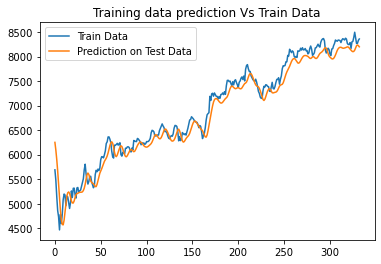

In [62]:
#We now visualise the training data and prediction
Xt = model.predict(X_train)

plt.plot(scl.inverse_transform(y_train.reshape(-1,1)) , label = 'Train Data')
print("Prediction Shape is: ", Xt.shape)

plt.plot(scl.inverse_transform(Xt), label = 'Prediction on Test Data')
prediction = scl.inverse_transform(Xt)
plt.legend()
plt.title('Training data prediction Vs Train Data')
plt.show()

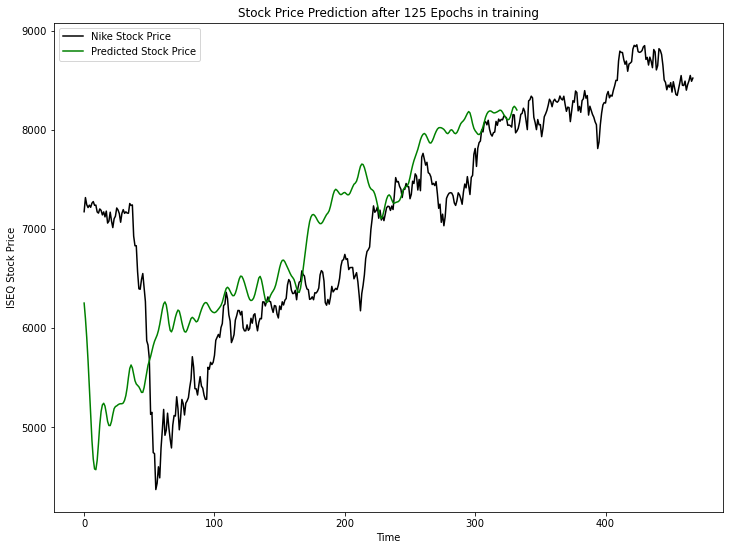

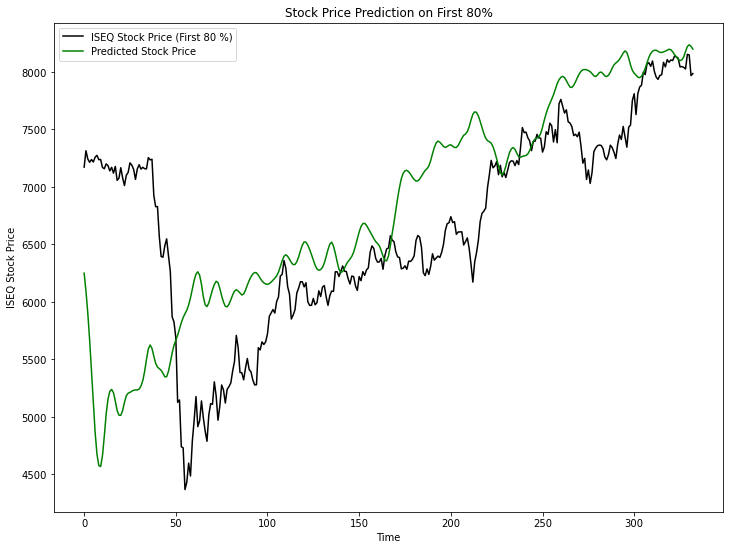

In [63]:
#We visualise the original data vs the Prediction of the final 20% of the stock data
prediction_main = np.zeros([468, 1], dtype = float) 
for i in range(0, 468):
    prediction_main[i] = None

for i in range(0, 333):
    prediction_main[i] = prediction[i]

final40NKE = np.zeros([84, 1], dtype = float) 
for i in range(384, 468):
    final40NKE[i-384] = stock[i]  
    
prediction_main2 = np.zeros([333, 1], dtype = float) 
for i in range(0, 333):
    prediction_main2[i] = prediction_main[i]

fig, ax = plt.subplots(figsize=(12,9))
plt.plot(stock, color = 'black', label = 'Nike Stock Price')
plt.plot(prediction_main, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction after %i Epochs in training' %num_epochs)
#plt.title('Stock Price Prediction after 100 Epochs in training')
plt.xlabel('Time')
plt.ylabel('ISEQ Stock Price')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12,9))    
plt.plot(stock[0:333, :], color = 'black', label = 'ISEQ Stock Price (First 80 %)')
plt.plot(prediction_main2, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction on First 80%')
plt.xlabel('Time')
plt.ylabel('ISEQ Stock Price')
plt.legend()

plt.show()


In [64]:
#Model Params
print("Model intercept (LSTM):", model)  # Printing model intercept
print()
#print("Model intercept (LSTM):", metrics.accuracy_score(y_test, Xt))  # Printing R Squared score
print("Mean absolute error (LSTM): \t", metrics.mean_absolute_error(y_train, Xt))  # Printing Mean absolute error
print("Mean squared error (LSTM): \t", metrics.mean_squared_error(y_train, Xt))  # Printing mean squared error
print("R squared (LSTM): \t\t", metrics.r2_score(y_train, Xt))  # Printing R Squared score

Model intercept (LSTM): <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000241CCD2F5B0>

Mean absolute error (LSTM): 	 0.03571302622802288
Mean squared error (LSTM): 	 0.0020214749425989257
R squared (LSTM): 		 0.9608498765513941


In [12]:
####################################
## TESTING and Cross validation ##
####################################

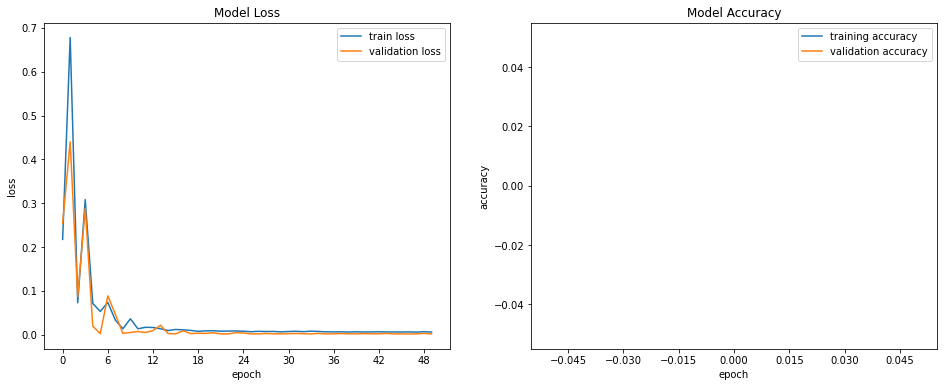

	Model Loss based on ISEQ stock data 
	based on batch size 160 


In [13]:
#Cross Validation     ~For Batch size

num_epochs = 50

mean_error=[]
std_error=[]
mean_absolute_error=[]
r_squared=[]
batchSize_range = [8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 128, 160]

for batchSizeX in batchSize_range:
    pltCallBack = PlotLossAccuracy()
    #Model already established above 
    #print("\tModel Loss based on ISEQ stock data \n\tafter %i Epochs in training" %num_epochs)
    temp=[]
    temp2=[]
    temp3=[]
    kf = KFold(n_splits=5)
    #Clear model before retraining 
    model.load_weights('model.h5')    
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
        epochs=num_epochs, callbacks=[PlotLossAccuracy()], batch_size=batchSizeX, verbose=1,shuffle=False) 
    print("\tModel Loss based on ISEQ stock data \n\tbased on batch size %i " %batchSizeX)
    ypred = model.predict(X_test)
    temp.append(metrics.mean_squared_error(y_test,ypred))
    temp2.append(metrics.mean_absolute_error(y_test,ypred))
    temp3.append(metrics.r2_score(y_test,ypred))
    mean_error.append(np.array(temp).mean())
    mean_absolute_error.append(np.array(temp2))
    r_squared.append(np.array(temp3))
    std_error.append(np.array(temp).std())

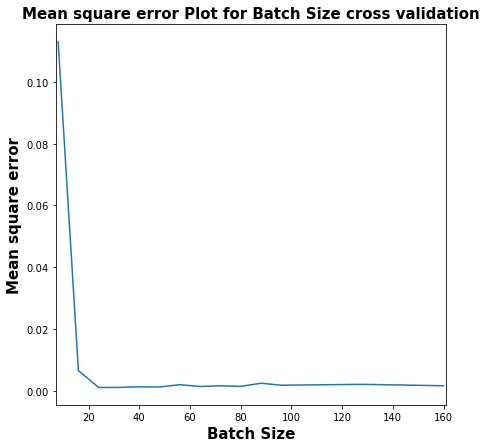

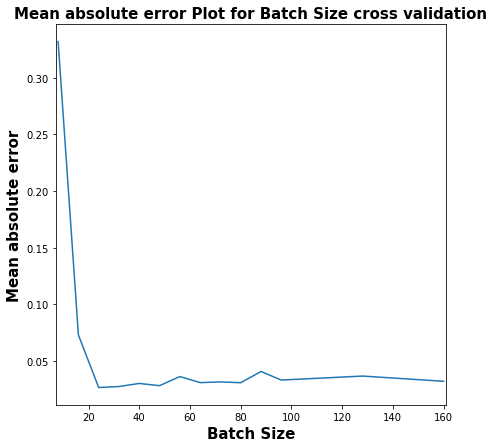

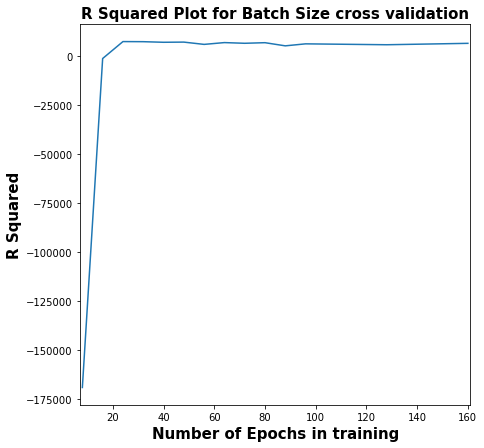

In [14]:
#Plot results of cross validation 
fig = plt.figure(figsize=(7, 7))
plt.errorbar(batchSize_range, mean_error, yerr=std_error)
plt.title('Mean square error Plot for Batch Size cross validation', fontsize=15, fontweight= 'bold')
plt.xlabel('Batch Size', fontsize=15, fontweight= 'bold')
plt.ylabel('Mean square error', fontsize=15, fontweight= 'bold')
plt.xlim((7,161))
plt.show()

fig = plt.figure(figsize=(7, 7))
plt.errorbar(batchSize_range, mean_absolute_error, yerr=std_error)
plt.title('Mean absolute error Plot for Batch Size cross validation', fontsize=15, fontweight= 'bold')
plt.xlabel('Batch Size', fontsize=15, fontweight= 'bold')
plt.ylabel('Mean absolute error', fontsize=15, fontweight= 'bold')
plt.xlim((7,161))
plt.show()

r_squared = scl.inverse_transform(r_squared)
fig = plt.figure(figsize=(7, 7))
plt.errorbar(batchSize_range, r_squared, yerr=std_error)
plt.title('R Squared Plot for Batch Size cross validation', fontsize=15, fontweight= 'bold')
plt.xlabel('Number of Epochs in training', fontsize=15, fontweight= 'bold')
plt.ylabel('R Squared', fontsize=15, fontweight= 'bold')
plt.xlim((7,161))
plt.show()

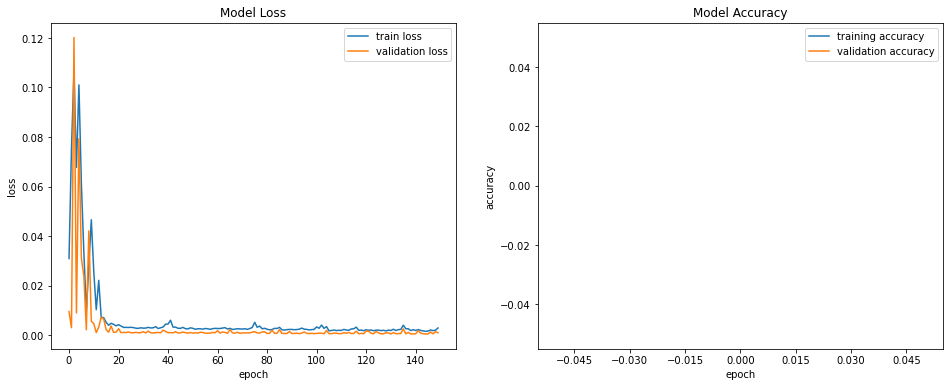

	Model Loss based on ISEQ stock data 
	based on 150 Epochs


In [42]:
#Cross Validation     ~For Epochs

num_epochs = 25

mean_error=[]
std_error=[]
r_squared=[]
mean_absolute_error=[]
predictions=[]
epochs_range = [5, 10, 15, 25, 35, 50, 60, 75, 90, 100, 115, 125, 150]

for Nepochs in epochs_range:
    pltCallBack = PlotLossAccuracy()
    #Model already established above 
    temp=[]
    temp2=[]
    temp3=[]
    temp4=[]
    kf = KFold(n_splits=5)
    #Clear model before retraining 
    model.load_weights('model.h5') 
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
        epochs=Nepochs, callbacks=[PlotLossAccuracy()], batch_size=24, verbose=1,shuffle=False) 
    print("\tModel Loss based on ISEQ stock data \n\tbased on %i Epochs" %Nepochs)
    ypred = model.predict(X_test)
    temp4.append(ypred)
    temp.append(metrics.mean_squared_error(y_test,ypred))
    temp2.append(metrics.mean_absolute_error(y_test,ypred))
    temp3.append(metrics.r2_score(y_test,ypred))
    mean_error.append(np.array(temp).mean())
    mean_absolute_error.append(np.array(temp2).mean())
    r_squared.append(np.array(temp3))
    std_error.append(np.array(temp).std())
    predictions.append(np.array(temp4))


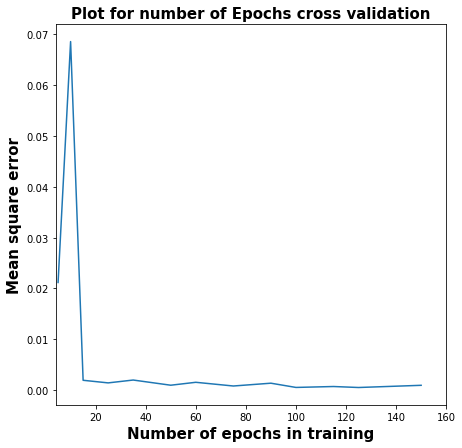

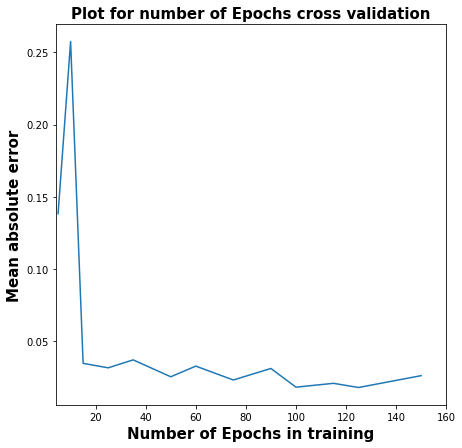

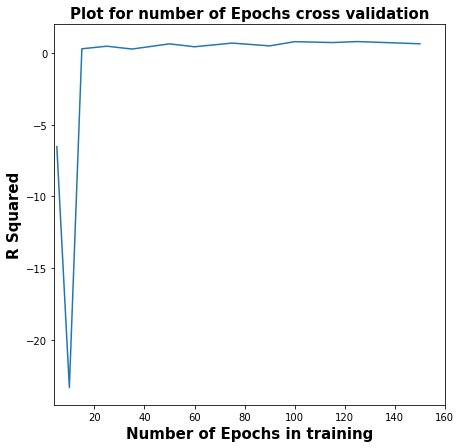

In [65]:
#Plot results of cross validation 
fig = plt.figure(figsize=(7, 7))
plt.errorbar(epochs_range, mean_error, yerr=std_error)
plt.title('Plot for number of Epochs cross validation', fontsize=15, fontweight= 'bold')
plt.xlabel('Number of epochs in training', fontsize=15, fontweight= 'bold')
plt.ylabel('Mean square error', fontsize=15, fontweight= 'bold')
plt.xlim((4,160))
plt.show()

fig = plt.figure(figsize=(7, 7))
plt.errorbar(epochs_range, mean_absolute_error, yerr=std_error)
plt.title('Plot for number of Epochs cross validation', fontsize=15, fontweight= 'bold')
plt.xlabel('Number of Epochs in training', fontsize=15, fontweight= 'bold')
plt.ylabel('Mean absolute error', fontsize=15, fontweight= 'bold')
plt.xlim((4,160))
plt.show()

fig = plt.figure(figsize=(7, 7))
plt.errorbar(epochs_range, r_squared, yerr=std_error)
plt.title('Plot for number of Epochs cross validation', fontsize=15, fontweight= 'bold')
plt.xlabel('Number of Epochs in training', fontsize=15, fontweight= 'bold')
plt.ylabel('R Squared', fontsize=15, fontweight= 'bold')
plt.xlim((4,160))
plt.show()